## Machine Learning using LSTM on Split 2

In [1]:
# Warnings are provided to warn the developer of situations that aren’t necessarily exceptions. 
#Usually, a warning occurs when there is some obsolete of certain programming elements.
#Python program terminates immediately if an error occurs. Conversely, a warning is not critical.

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

2023-05-25 14:11:00.704332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Importing the stored components

In [3]:
%store -r df_train2
%store -r df_test2
%store -r df_val2
%store -r df_validation2
%store -r input_col2
%store -r target_col2
%store -r minmax_scaler2

#### Splitting into x and y from input and target columns

In [4]:
X_train = df_train2[input_col2].to_numpy()
y_train = df_train2[target_col2].to_numpy()

X_val = df_val2[input_col2].to_numpy()
y_val = df_val2[target_col2].to_numpy()

X_test = df_test2[input_col2].to_numpy()
y_test = df_test2[target_col2].to_numpy()

### Creating sequences for the training set, validation set and test set to fit into the LSTM

In [5]:
def create_sequences(data, target, seq_length):
    X = []
    y = []

    for i in range(len(data) - seq_length):
        # Create input sequence
        seq = data[i:i + seq_length]
        # Append the target value (value at the next timestep) for the given sequence
        X.append(seq)
        y.append(target[i + seq_length])

    return np.array(X), np.array(y)


# Example usage:
sequence_length = 50
target_feature = 'DownholePressure'  # The feature you want to predict

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

### Defining the layers and architecture of the LSTM model

In [6]:
n_features = X_train_seq.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))


2023-05-25 14:11:16.410371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.summary()

### Fitting the LSTM on Training Set

In [ ]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)


### Saving in order to skip the time consuming training

In [ ]:
model.save('LSTM Train Split 2.h5')

In [35]:
loaded_model = load_model('LSTM Train Split 2.h5', compile=False)
loaded_model.compile(optimizer='adam', loss='mse')

### Predict the validation set and calculate the error metrics and r^2 score

In [10]:
# Make predictions using the model
y_pred = loaded_model.predict(X_val_seq)

# Flatten y_val_seq and y_pred for error calculations
y_val_seq_flat = y_val_seq.flatten()
y_pred_flat = y_pred.flatten()

1986/1986 [==============================] - 23s 11ms/step


In [11]:
# Calculate MSE
mse = mean_squared_error(y_val_seq_flat, y_pred_flat)

# Calculate RMSE
rmse = sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_val_seq_flat, y_pred_flat)

# Calculate R2 Score
r2 = r2_score(y_val_seq_flat, y_pred_flat)

print("Validation MSE:", mse)
print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R2 Score:", r2)

Validation MSE: 0.0025273014152024254
Validation RMSE: 0.05027227282710048
Validation MAE: 0.0450001933113782
Validation R2 Score: 0.7554650628264478


### Predict the test set and calculate the error metrics and r^2 score

In [12]:
# Make predictions using the model
y_pred = loaded_model.predict(X_test_seq)

# Flatten y_test_seq and y_pred for error calculations
y_test_seq_flat = y_test_seq.flatten()
y_pred_flat = y_pred.flatten()

1028/1028 [==============================] - 10s 9ms/step


In [13]:
# Calculate MSE
mse = mean_squared_error(y_test_seq_flat, y_pred_flat)

# Calculate RMSE
rmse = sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_test_seq_flat, y_pred_flat)

# Calculate R2 Score
r2 = r2_score(y_test_seq_flat, y_pred_flat)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R2 Score:", r2)

Test MSE: 0.0009895806279173512
Test RMSE: 0.03145760047933331
Test MAE: 0.025689665145371847
Test R2 Score: 0.9229116686021281


### Unscaling the data if the test splot should be with real numbers

In [33]:
def invert_scaling(y_values, target_scaler, apply_inverse=True):
    if apply_inverse:
        # Invert the scaling
        y_values_inverted = target_scaler.inverse_transform(y_values.reshape(-1, 1))
    else:
        # Don't invert the scaling
        y_values_inverted = y_values
    return y_values_inverted.ravel()

# Set apply_inverse to False if you want scaled values, True if you want real values
apply_inverse = False

# Create a new scaler fitted on the 'DownholePressure' column of the training data
target_scaler = minmax_scaler2

# Invert the scaling of the predicted and true DownholePressure values
y_pred_inverted = invert_scaling(y_pred, target_scaler, apply_inverse)
y_test_inverted = invert_scaling(y_test_seq, target_scaler, apply_inverse)

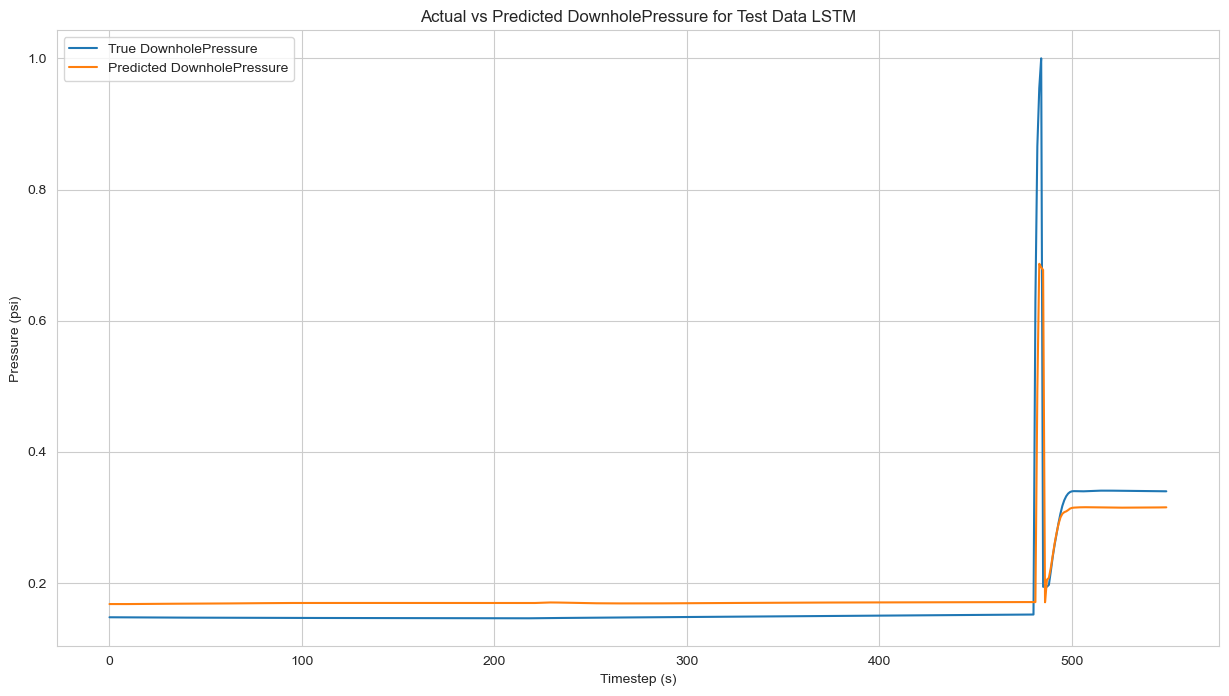

In [34]:
# Select the first 600 steps
y_test_inverted_600 = y_test_inverted[:550]
y_pred_inverted_600 = y_pred_inverted[:550]

# Plot the true DownholePressure values against the predicted values
plt.figure(figsize=(15, 8))
plt.plot(y_test_inverted_600, label='True DownholePressure')
plt.plot(y_pred_inverted_600, label='Predicted DownholePressure')
plt.title('Actual vs Predicted DownholePressure for Test Data LSTM')
plt.xlabel('Timestep (s)')
plt.ylabel('Pressure (psi)')
plt.legend()
plt.show()

### Testing the LSTM on a new online unseen dataset

In [17]:
%store -r df_validation

In [18]:
# Define the input features and target features
X_validation = df_validation[input_col2].to_numpy()
y_validation = df_validation[target_col2].to_numpy()

# Create sequences from the scaled validation data
sequence_length = 50
X_validation_seq, _ = create_sequences(X_validation, np.zeros(X_validation.shape[0]), sequence_length)

# Use the LSTM model to predict the DownholePressure values for each sequence
y_pred_validation = loaded_model.predict(X_validation_seq)

18/18 [==============================] - 0s 11ms/step


In [19]:
# Adjust the true values to match the length of predictions
y_validation = y_validation[sequence_length:]

# Calculating MSE
mse = mean_squared_error(y_validation, y_pred_validation)
print(f'Mean Squared Error: {mse}')

# Calculating MAE
mae = mean_absolute_error(y_validation, y_pred_validation)
print(f'Mean Absolute Error: {mae}')

# Calculating R2 Score
r2 = r2_score(y_validation, y_pred_validation)
print(f'R^2 Score: {r2}')

# Calculating RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Square Error: {rmse}')

Mean Squared Error: 0.01018384695329394
Mean Absolute Error: 0.06906031038570692
R^2 Score: -0.7858699962646118
Root Mean Square Error: 0.1009150482004242


In [23]:
# Invert the scaling of the predicted DownholePressure values
target_scaler = minmax_scaler2
target_scaler.min_, target_scaler.scale_ = minmax_scaler2.min_[target_index], minmax_scaler2.scale_[target_index]
target_index = 5


y_pred_validation_last_col = y_pred_validation[:, -1].reshape(-1, 1)
y_pred_validation_inverted = target_scaler.inverse_transform(np.concatenate((np.zeros((y_pred_validation_last_col.shape[0], target_index)), y_pred_validation_last_col, np.zeros((y_pred_validation_last_col.shape[0], target_scaler.n_features_in_ - target_index - 1))), axis=1))[:, target_index]

# Invert the scaling of the actual DownholePressure values
y_validation_last_col = y_validation.reshape(-1, 1)
y_validation_inverted = target_scaler.inverse_transform(np.concatenate((np.zeros((y_validation_last_col.shape[0], target_index)), y_validation_last_col, np.zeros((y_validation_last_col.shape[0], target_scaler.n_features_in_ - target_index - 1))), axis=1))[:, target_index]


In [24]:
#Invert the scaling of the predicted DownholePressure values and the actual values
y_pred_validation_inverted = target_scaler.inverse_transform(y_pred_validation)

y_validation_inverted = target_scaler.inverse_transform(y_validation)

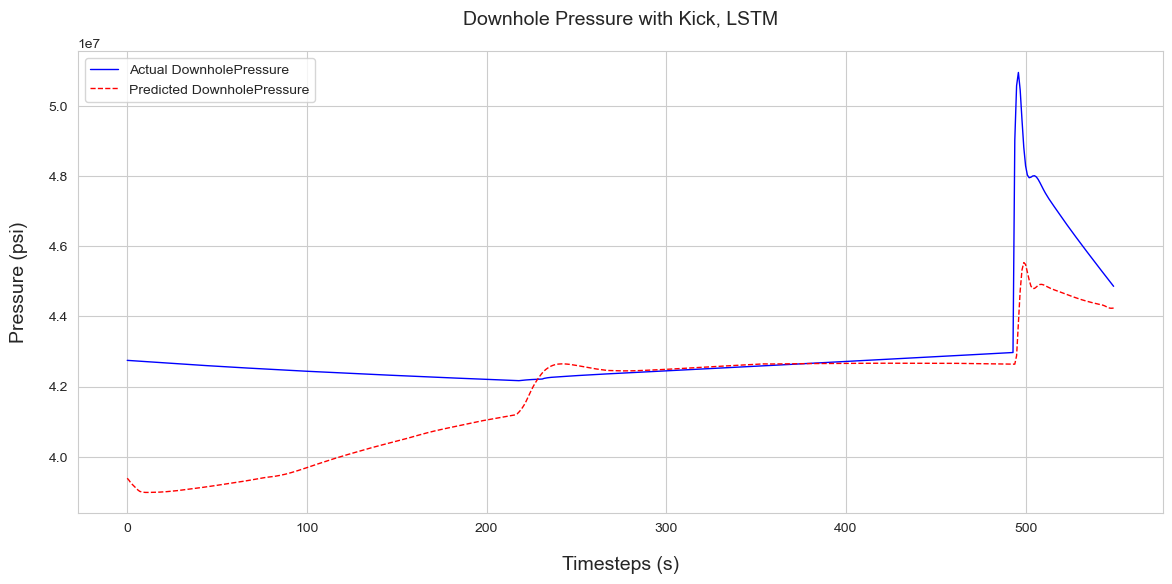

In [25]:
# Set the alpha value you want for your gridlines. 1 is opaque, 0 is transparent
alpha = 0.3

# Get the grid color
gridcolor = mpl.rcParams['grid.color']

# Convert the grid color to RGBA
rgba = mcolors.to_rgba(gridcolor)

# Create a new color with the adjusted alpha
new_color = (rgba[0], rgba[1], rgba[2], alpha)

# Convert the new color back to a hex string
new_color_hex = mcolors.to_hex(new_color)

# Set the new grid color
mpl.rcParams['grid.color'] = new_color_hex

# Use seaborn style
sns.set_style("whitegrid")

# Create a time vector for the validation data
time_validation = np.arange(0, len(y_pred_validation_inverted.flatten()))

# Create a figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the actual DownholePressure values with seaborn
sns.lineplot(x=time_validation, y=y_validation_inverted.flatten(), label='Actual DownholePressure', color='blue', linewidth=1)

# Plot the predicted DownholePressure values with seaborn
sns.lineplot(x=time_validation, y=y_pred_validation_inverted.flatten(), label='Predicted DownholePressure', color='red', linewidth=1, linestyle='--')

# Set the x-label, y-label, and title
ax.set_xlabel('Timesteps (s)', fontsize=14, labelpad=15)
ax.set_ylabel('Pressure (psi)', fontsize=14, labelpad=15)
ax.set_title('Downhole Pressure with Kick, LSTM', fontsize=14, pad=20)

# Adjust the legend
ax.legend(frameon=True, fontsize=10)

plt.show()
